# Neural & Behavioral Modeling - Week 15 (Exercises)
by 林子堯 (r08227112@ntu.edu.tw)

In [223]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
from math import *

## 1 Integrate-and-Fire Neuron with A Refractory Period (5 points)

Please modify the leaky integrate-and-fire model to produce the following dynamics showing <a href="https://en.wikipedia.org/wiki/Refractory_period_(physiology)">refractory/inactivation periods</a> like the following:

<img src="https://courses.cit.cornell.edu/ece5990/ECE5725_Fall2017_projects/aj373_ssd56_website/images/centerLED.png" width=70%>

Unlike the above figure, you need to produce "spikes" in your implementation.

### 1.0 The Leaky Integrate-and-Fire Model

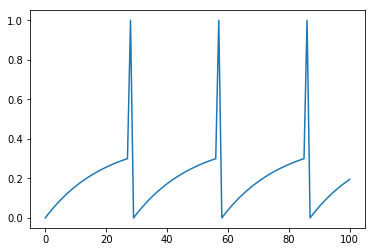

In [2]:
I=2;g=5;C=10;Vrst=0;Vthr=.3;Vspk=1;

dt=.1; V=[Vrst];
for t in np.arange(0,10,dt):
    V1=V[-1] # the last element
    s=V1>Vthr; # An implicit IF-THEN hack
    V2=s*Vrst+(1-s)*(V1+dt/C*(-g*V1+I)) # Euler integration
    V1=s*Vspk+(1-s)*V1 # Spiking now?
    V[-1]=V1; V.append(V2)

plot(V);

### 1.1 Your modified I-F model

其這一部份很簡單加個計數器就能達成，也就是我們設定當電位到達最低值時，把後續 C 段時間的電位都設成 0，再接回原始程式設定就能模擬出不反應期了。

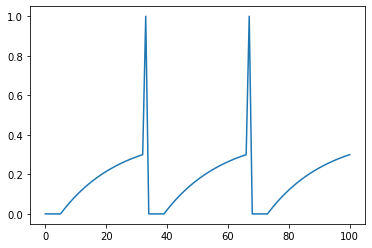

In [57]:
# Please write your codes here.

I=2;g=5;C=10;Vrst=0;Vthr=.3;Vspk=1;
refractory_period = .5;
refractory_count = 0;

dt=.1; V=[Vrst];
for t in np.arange(0,10,dt):
    if refractory_count < refractory_period:
        refractory_count += dt
        V.append(0)
        continue
    else:
        V1=V[-1] # the last element
        s=V1>Vthr; # An implicit IF-THEN hack
        V2=s*Vrst+(1-s)*(V1+dt/C*(-g*V1+I)) # Euler integration
        V1=s*Vspk+(1-s)*V1 # Spiking now?
        V[-1]=V1; 
        V.append(V2)
        refractory_count = (1-s) * refractory_count
plot(V);

## 2 The Hodgkin–Huxley Model (5 points)
Please read P.19, P.20, & P.21 of the article by <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392413/pdf/jphysiol01442-0106.pdf">Hodgkin & Huxley (1952)</a>
to implement the very original Hodgkin–Huxley model using their equations and parameters.

### 2.0 Modern implementation of the H-H model

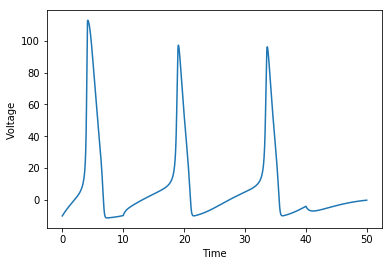

In [4]:
# Integration of Hodgkin--Huxley equations with Euler method
g=np.array([36, 120, 0.3]) # Maximal conductances (in units of mS/cm^2); 1=K, 2=Na, 3=l
E=np.array([-12, 115, 10.613]) # Resting potentials (in mV):
# Some initializations: some variables
gnmh=np.zeros(3); Alpha=np.zeros(3); Beta=np.zeros(3); x=np.zeros(3); 
x[2]=1; I_ext=0; V=[-10]; dt=0.01; 

tspan=np.arange(0,50,dt)
for t in tspan:
    
    V1=V[-1] # the last element
    if(t>=10 and t<=40):
        I_ext=10  # turns external current on when t=[10,40]
    else:  
        I_ext=0   
        
  # alpha functions:
    Alpha[0]=0.01*(10-V1)/(np.exp((10-V1)/10)-1)
    Alpha[1]=0.1*(25-V1)/(np.exp((25-V1)/10)-1)
    Alpha[2]=0.07*np.exp(-V1/20)
    
  # beta functions:
    Beta[0]=0.125*np.exp(-V1/80)
    Beta[1]=4*np.exp(-V1/18)
    Beta[2]=1/(np.exp((30-V1)/10)+1)
    
  # tau_x and x_0 (x=0,1,2) are defined with alpha and beta
    tau=1/(Alpha+Beta);
    x_inf=Alpha*tau;
    x=x+dt*(x_inf-x)/tau;
    
  # calculate actual conductances g with given n, m, h
    gnmh[0]=g[0]*x[0]**4;
    gnmh[1]=g[1]*x[1]**3*x[2];
    gnmh[2]=g[2];
    
  # Ohm's law
    I=gnmh*(V1-E);
    V2=V1+dt*(I_ext-sum(I))
    V.append(V2)
    
plot(tspan,V[:-1]); 
xlabel('Time'); ylabel('Voltage');

### 2.1 Your implementation of the original H-H model

Hodgkin & Huxley (1952) 的模型如下所式：

$$
I = C_M\frac{dV}{dt} + \bar{g}_K n^4 (V - V_k) + \bar{g}_{Na} m^3 h (V - V_{Na}) + \bar{g}_l (V - V_l)
$$

其中

$$
\frac{dn}{dt} = \alpha_n (1 - n) -\beta_n n \\
\frac{dm}{dt} = \alpha_m (1 - m) -\beta_m m \\
\frac{dh}{dt} = \alpha_h (1 - h) -\beta_h h \\
\alpha_n = 0.01 (V + 10) \Big/ \left( exp(\frac{V + 10}{10}) - 1 \right) \\
\beta_n = 0.125 exp(V / 80) \\
\alpha_m = 0.1 (V + 25) \Big/ \left( exp(\frac{V + 25}{10}) - 1 \right) \\
\beta_m = 4 exp(V / 18) \\
\alpha_h = 0.07 exp(V / 20) \\
\beta_h = 1 \Big/ \left( exp(\frac{V + 30}{10}) + 1 \right)
$$

依照上述模型並搭配該論文表 3 第二直欄對參數值的設定 (使膜電位的均衡態為 0)，下方為我實作的程式碼，

In [206]:
# Please write your codes here.

# initial value, see Table 3
C_M = 1.0
V_Na = -115; V_K = 12; V_l = -10.613
g_Na = 120; g_K = 36; g_l = 0.3

# custom function
def alpha_n_(V):
    return .01 * (V + 10) / (exp((V + 10) / 10) - 1) # eq. (12)

def beta_n_(V):
    return 0.125 * exp(V / 80) # eq. (13)

def alpha_m_(V):
    return 0.1 * (V + 25) / (exp((V + 25) / 10) - 1) # eq. (20)

def beta_m_(V):
    return 4 * exp(V / 18) # eq. (21)

def alpha_h_(V):
    return 0.07 * exp(V / 20) # eq. (23)
    
def beta_h_(V):
    return 1 / (exp((V + 30) / 10) + 1) # eq. (24)

def n_inf_(V):
    return alpha_n_(V) / (alpha_n_(V) + beta_n_(V))

def m_inf_(V):
    return alpha_m_(V) / (alpha_m_(V) + beta_m_(V))

def h_inf_(V):
    return alpha_h_(V) / (alpha_h_(V) + beta_h_(V))

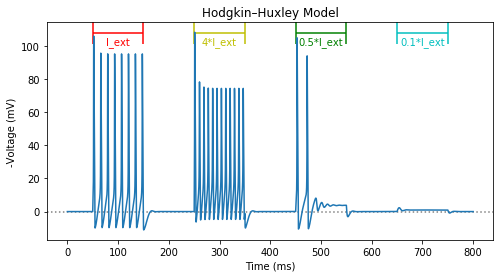

In [260]:
# model simulation 
V = [0]; n = [n_inf_(V[0])]; m = [m_inf_(V[0])]; h = [h_inf_(V[0])]
I_ext = -12
dt = 0.01

tspan = np.arange(0,800,dt)
for t in tspan:

    if(t >= 50 and t <= 150):
        I = I_ext  # turns external current on
    elif (t >= 250 and t <= 350):
        I = 4 * I_ext
    elif (t >= 450 and t <= 550):
        I = 0.5 * I_ext
    elif (t >= 650 and t <= 750):
        I = 0.1 * I_ext        
    else:  
        I = 0 

    V1 = V[-1]; n1 = n[-1]; m1 = m[-1]; h1 = h[-1]

    alpha_n = alpha_n_(V1)
    beta_n = beta_n_(V1)
    alpha_m = alpha_m_(V1)
    beta_m = beta_m_(V1)
    alpha_h = alpha_h_(V1)
    beta_h = beta_h_(V1)

    n2 = n1 + dt * (alpha_n * (1 - n1) - beta_n * n1) # eq. (7)
    m2 = m1 + dt * (alpha_m * (1 - m1) - beta_m * m1) # eq. (15)
    h2 = h1 + dt * (alpha_h * (1 - h1) - beta_h * h1) # eq. (16)

    K = g_K * (n2**4) * (V1 - V_K) 
    Na = g_Na * (m2**3) * h2 * (V1 - V_Na)
    l = g_l * (V1 - V_l)
    V2 = V1 + 1 / C_M * dt * (I - K - Na - l) # eq. (26)

    V.append(V2); n.append(n2); m.append(m2); h.append(h2)

# plot result
negV = - np.array(V[:-1])

rcParams["figure.figsize"] = (8, 4)
fig, ax = subplots()
ax.plot(tspan,negV)
ax.set_title("Hodgkin–Huxley Model")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("-Voltage (mV)")
ax.vlines([50, 150], 0.9, 1, transform = ax.get_xaxis_transform(), colors = "r")
ax.hlines(0.95, 50, 150, transform = ax.get_xaxis_transform(), colors = "r")
ax.text(100, 0.9, "I_ext", transform = ax.get_xaxis_transform(), horizontalalignment = "center", fontsize = 10, color = "r")
ax.vlines([250, 350], 0.9, 1, transform = ax.get_xaxis_transform(), colors = "y")
ax.hlines(0.95, 250, 350, transform = ax.get_xaxis_transform(), colors = "y")
ax.text(300, 0.9, "4*I_ext", transform = ax.get_xaxis_transform(), horizontalalignment = "center", fontsize = 10, color = "y")
ax.vlines([450, 550], 0.9, 1, transform = ax.get_xaxis_transform(), colors = "g")
ax.hlines(0.95, 450, 550, transform = ax.get_xaxis_transform(), colors = "g")
ax.text(500, 0.9, "0.5*I_ext", transform = ax.get_xaxis_transform(), horizontalalignment = "center", fontsize = 10, color = "g")
ax.vlines([650, 750], 0.9, 1, transform = ax.get_xaxis_transform(), colors = "c")
ax.hlines(0.95, 650, 750, transform = ax.get_xaxis_transform(), colors = "c")
ax.text(700, 0.9, "0.1*I_ext", transform = ax.get_xaxis_transform(), horizontalalignment = "center", fontsize = 10, color = "c")
ax.hlines(0, 0, 1, transform = ax.get_yaxis_transform(), colors = "gray", linestyle = ":")

結果如上圖所示，H-H model 確實能刻畫出膜電位反應的曲線 (spike)。其中我有做三個比較特別的設定:

1. 由於 Hodgkin & Huxley (1952) 當時對 voltage 定義的方向與現今習慣的方式剛好相反，因此我在做圖上 y 軸的數值有多加個負號，便於我們閱讀理解。

2. 我去操弄不同時間點給予不同的刺激電流 (I_ext) 的強度，來看此模型會有怎樣的反應。發現 
    
    - $t \in [50, 150]$ 的電流強度為 I_ext 時，共有 8 spikes / 100 ms；
    - $t \in [250, 350]$ 的電流強度增強道為 4 * I_ext 時，則有 12 spikes / 100 ms，反應的頻率增加了； 
    - $t \in [450, 550]$ 的電流強度減弱為 0.5 * I_ext 時，則只有 2 spikes / 100 ms，反應的頻率大幅降低；
    - $t \in [650, 750]$ 的電流強度減弱為 0.1 * I_ext 時，則沒有反應；

在以前生物學學到神經反應獨立於刺激的強度，如果刺激超過閾電位，神經就會有對應反應；否則，就完全不會有反應。在此次模擬中也有對此「全有全無律」做個印證，當刺激要足夠大時動作電位才會有較大的變化，而不夠大時則不會有，此外在 (足夠大下) 刺激強度大小並不影響電位最大值，而是反應在 spike 的頻率上，也就是說刺激越大反應頻率也會越大。

3. 由於我想操弄在特定的時間區段有刺激的輸入，也就是想讓其他時間區段時神經是不會有反應的，因此有考慮 n, m, h 初始的設定就能達到均衡態 ($V(t=0) = 0$)，所以才能看到 t 在 0~50 ms 間是沒有反應的。若沒有特別設定初始值的話很容易在模擬之初就會有動作電位產生，像是老師在 2.0 的範例中，明明刺激輸入是在 $10 < t < 40$ 之間，但是圖卻顯示 t 在一開始就有一個動作電位出現，我覺得這個部分在模擬上可能須注意一下。
